In [118]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import numpy as np
from scipy.optimize import curve_fit
import glob

import images_library


def line(x, m, q): 
    return m*x+q

def lineOneParam(x, m): 
    return m*x

In [119]:

#3/11/22

signalGyDict = {'70cGy': [[], [], [0.79, 0.80, 0.80] ], 
                   '300cGy': [[],[], [4.08, 3.99, 4.08]], 
                   '600cGy': [[],[], [6.27, 6.27, 6.18]], 
                   '9Gy': [[],[], [9.66, 9.56, 9.56]], 
                   '12Gy': [[],[], [12.52, 12.52, 12.52]], 
                   '15Gy': [[],[], [14.98, 14.68, 14.68]], 
                   '18Gy': [[],[], [16.93, 17.08, 16.93]],
                   '20Gy': [[],[], [19.13, 19.13, 19.13]], 
                   '23Gy': [[],[], [21.43, 21.43, 21.43]], 
                   }
darkFiles = glob.glob(f"20221102_Flash/2022_11_03_flash_1mm/sat/*buio*.TIF") 
saturationDirectory = "20221102_Flash/2022_11_03_flash_1mm/sat"
cenX, cenY= 273, 237 
title= "03/11/22"

"""
#4/11/22
signalGyDict = {'07Gy': [[], [], [0.59, 0.62, 0.64] ], 
                   #'3Gy': [[],[], [3.73, 3.73, 3.73]], 
                   '6Gy': [[],[], [5.55, 5.64, 5.64]], 
                   '9Gy': [[],[], [8.90, 8.90, 8.90]], 
                   '12Gy': [[],[], [11.74, 11.55, 11.74]], 
                   '15Gy': [[],[], [14.23, 14.23, 14.08]], 
                   '18Gy': [[],[], [16.93, 16.93, 16.47]],
                   '20Gy': [[],[], [18.16, 18.32, 18.]], 
                   '23Gy': [[],[], [20.93, 20.59, 20.26]], 
                   }
darkFiles = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*buio*.TIF")
saturationDirectory = "20221102_Flash/2022_11_04_flash_1mm/sat/f11"
cenX, cenY= 254, 230 
title ="04/11/22"
"""

'\n#4/11/22\nsignalGyDict = {\'07Gy\': [[], [], [0.59, 0.62, 0.64] ], \n                   #\'3Gy\': [[],[], [3.73, 3.73, 3.73]], \n                   \'6Gy\': [[],[], [5.55, 5.64, 5.64]], \n                   \'9Gy\': [[],[], [8.90, 8.90, 8.90]], \n                   \'12Gy\': [[],[], [11.74, 11.55, 11.74]], \n                   \'15Gy\': [[],[], [14.23, 14.23, 14.08]], \n                   \'18Gy\': [[],[], [16.93, 16.93, 16.47]],\n                   \'20Gy\': [[],[], [18.16, 18.32, 18.]], \n                   \'23Gy\': [[],[], [20.93, 20.59, 20.26]], \n                   }\ndarkFiles = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*buio*.TIF")\nsaturationDirectory = "20221102_Flash/2022_11_04_flash_1mm/sat/f11"\ncenX, cenY= 254, 230 \ntitle ="04/11/22"\n'

In [120]:
saturationFiles=[]
for k in signalGyDict.keys():
    f=glob.glob(f"%s/*%s*.TIF" %(saturationDirectory, k))
    saturationFiles.append(sorted(f))
saturationFiles=np.array(saturationFiles)


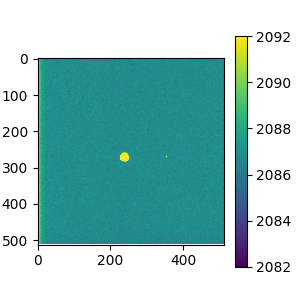

In [121]:
#Find the mean dark: takes all the dark images and calulate the maean image (sum/n of images)
darkImage=np.zeros(images_library.openImage(darkFiles[0]).shape)
for d in darkFiles:
    darkImage += images_library.openImage(d)
dark=darkImage/len(darkFiles)
images_library.plotImage(dark, title='', bounds=[2082, 2092])

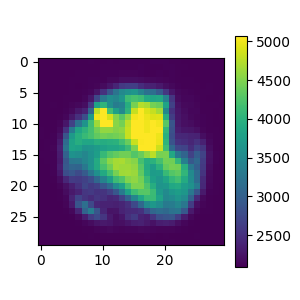

In [122]:
#Check the centering of the ROI
imArray=images_library.openImage(saturationFiles[0][0])
x, y = np.ogrid [:len(imArray) , :len(imArray)]
images_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r=15))


In [123]:
"""
inputfile = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*3Gy*1.TIF")
imArray=images_library.openImage(inputfile[0])
images_library.plotImage(imArray)

images_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r=15))
"""

'\ninputfile = glob.glob(f"20221102_Flash/2022_11_04_flash_1mm/sat/f11/*3Gy*1.TIF")\nimArray=images_library.openImage(inputfile[0])\nimages_library.plotImage(imArray)\n\nimages_library.plotImage(images_library.applySquareROI(imArray, cenX, cenY, r=15))\n'

In [124]:
"""
    This function makes the subtraction of the data images with the dark (mean dark) in a selected ROI. 
    It accepts in input: 
    It returns the dictionary filled with the signal and the standard deviation

"""
def findSignal(dataFiles, darkImage, ROI, outputDict, repetition=3):
    i=0
    for k,i in zip(outputDict.keys(), range(0, len(outputDict.keys()))):
        signalsList = []
        signalErrorsList = []
        for j in range(0, repetition):
            imArray=images_library.openImage(dataFiles[i][j])
            signalsList.append(np.mean(imArray[ROI]-darkImage[ROI]))
            stDev = np.std(imArray[ROI]-darkImage[ROI])
            stDevOfMean = stDev/np.sqrt(len(np.argwhere(ROI==True)))
            signalErrorsList.append(stDevOfMean)   
        outputDict[k][0]=signalsList
        outputDict[k][1]=signalErrorsList
        i=i+1    
    return outputDict



"""
    Create lists from dictionary values
"""
def covertDictToArray(inputDict): 
    x =[]
    y =[]
    dy = []
    for k in inputDict.keys():
        y.append(inputDict[k][0])
        dy.append(inputDict[k][1])
        x.append(inputDict[k][2])
    x = [val for sublist in x for val in sublist]
    y = [val for sublist in y for val in sublist]
    dy = [val for sublist in dy for val in sublist]
    outputArray = np.array([x,y,dy])
    return outputArray

def fitLine(x, y, dy):
    opt, pcov = curve_fit(line, x, y, sigma=dy)
    optErr = np.sqrt(pcov.diagonal())
    return opt, optErr

def fitLineOneParam(x, y, dy):
    opt, pcov = curve_fit(lineOneParam, x, y, sigma=dy)
    optErr = np.sqrt(pcov.diagonal())
    return opt, optErr


def ratioErr(a, b, da, db): 
    df = np.sqrt((da/b)**2 + (a/b * db/b)**2)
    return df 

In [125]:
"""
    Scan to find the signal (mean and standard deviation) in the ROI for different ROI dimensions:
    - first decide the ROI dimension (radius)
    - fill the dictionary with the mean and st deviation of the signal
    - create an array with signal, signal error and dose 
"""
dataForDifferentROIs = []
rROI = []
for r in range(10, 11):
    ROI=images_library.defineROI(x, y, cenX, cenY, r)
    signalGyDict = findSignal(saturationFiles, dark, ROI, signalGyDict, repetition=3)
    dataROI = covertDictToArray(signalGyDict)
    dataForDifferentROIs.append(dataROI)
    rROI.append(r)

[0.9458] [-2.3494]



[ 0.79  0.8   0.8   4.08  3.99  4.08  6.27  6.27  6.18  9.66  9.56  9.56
 12.52 12.52 12.52 14.98 14.68 14.68 16.93 17.08 16.93 19.13 19.13 19.13
 21.43 21.43 21.43] [0.0409 0.0405 0.0402 0.2031 0.2034 0.2027 0.3134 0.3119 0.3118 0.4737
 0.4736 0.4715 0.6374 0.6388 0.636  0.7583 0.7308 0.7389 0.842  0.8453
 0.8426 0.918  0.9181 0.9185 1.0001 1.0016 1.    ] [0.0011 0.0011 0.0011 0.0054 0.0054 0.0054 0.0083 0.0083 0.0082 0.0125
 0.0125 0.0125 0.0167 0.0168 0.0167 0.0197 0.0191 0.0193 0.0213 0.0214
 0.0213 0.0224 0.0224 0.0225 0.0234 0.0234 0.0234] [ 5.0931e-04 -3.9127e-04 -6.3703e-04  1.0273e-03  5.7669e-03  6.3363e-04
  3.6113e-03  2.1046e-03  6.4211e-03 -2.7058e-03  2.0879e-03 -3.0636e-05
  2.0366e-02  2.1751e-02  1.9006e-02  2.0377e-02  7.6151e-03  1.5745e-02
  8.1776e-03  4.1361e-03  8.8054e-03 -2.3989e-02 -2.3833e-02 -2.3434e-02
 -5.4967e-02 -5.3465e-02 -5.5017e-02]


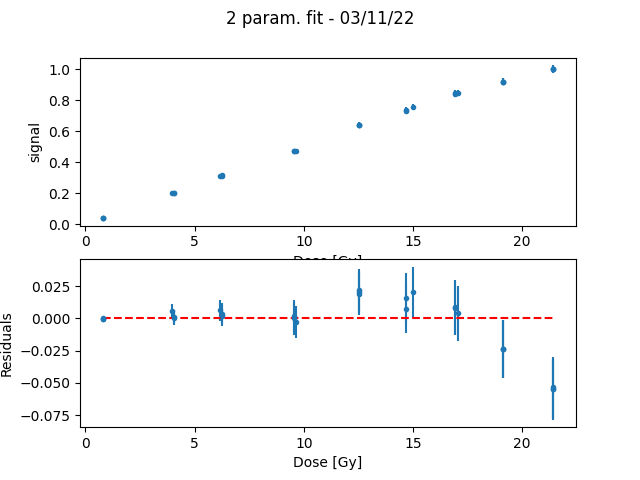

In [126]:
#Make a fit of the line, normalising to the biggest value  
normalizationPointIndex = -1
maxIndexForFit = -1

fitParam=[]
chi2Norm = []
significaty = []

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xlabel("Dose [Gy]")
ax1.set_ylabel("signal")
ax2.set_xlabel("Dose [Gy]")
ax2.set_ylabel("Residuals")
fig.suptitle("2 param. fit - " +title)


#for maxIndexForFit in [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]:
for r in range(0, len(rROI)):
    #r=0
    x = dataForDifferentROIs[r][0]
    y = dataForDifferentROIs[r][1]
    dy = dataForDifferentROIs[r][2]    
    normalizationValue=y[normalizationPointIndex]
    y = y/normalizationValue
    dy = dy/normalizationValue
    opt, optErr = fitLine(x[:maxIndexForFit], y[:maxIndexForFit], dy[:maxIndexForFit])
    fitParam.append(opt)
    
    residuals=y-line(x,*opt)
    chi2 = np.sum((residuals[:maxIndexForFit])**2 / dy[:maxIndexForFit]**2)
    ndof = len(x[:maxIndexForFit])-1
    chi2Norm.append(chi2/ndof)   
    significaty.append(residuals[-1]/dy[-1])
    
    ax1.errorbar(x, y, yerr=dy, fmt='.')
    ax2.errorbar(x, residuals, yerr=dy, fmt='.')
    
    
ax2.plot(np.linspace(x.min(), x.max(), 1000), line(np.linspace(x.min(), x.max(), 1000), 0, 0), '--r')
    
fitParam=np.array(fitParam)
chi2Norm = np.array(chi2Norm)
significaty = np.array(significaty)
np.set_printoptions(precision=4)
print(chi2Norm, significaty)


print('\n\n')
print(x, y, dy, residuals)
data = np.transpose([x, y, dy, residuals])
fmt = "%.4f, %.4f, %.4f, %.4f"
np.savetxt("saturation_R10_3novembre.txt", data, fmt = fmt)

[0.9458]


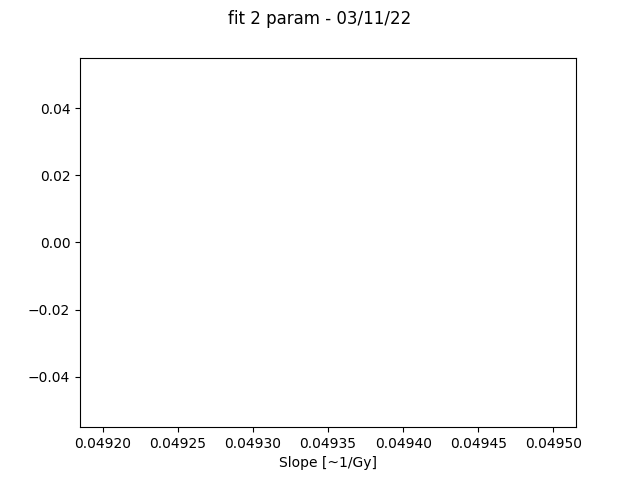

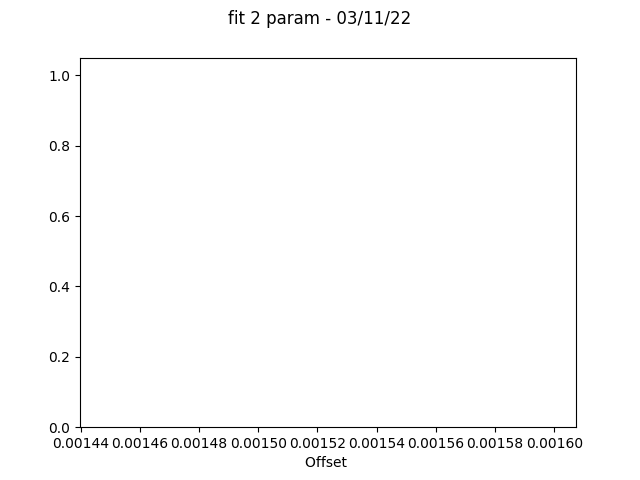

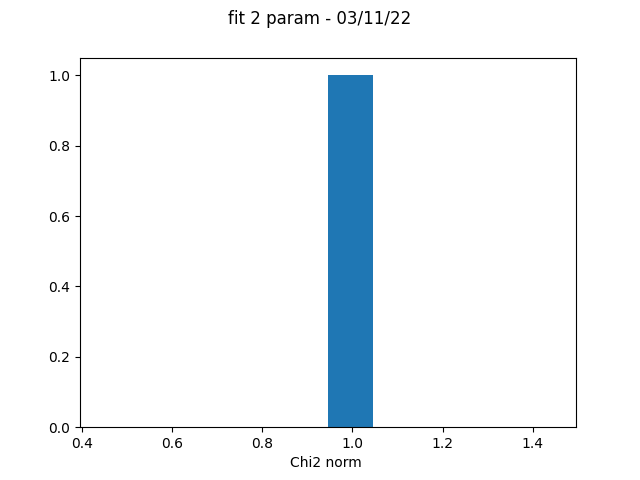

In [127]:
# Look at the histograms of the fit parameters
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Slope [~1/Gy]")
ax.hist(fitParam[:,0], bins= np.linspace(0.0492, 0.0495, 10))
fig.suptitle("fit 2 param - "+title)

fig, ax = plt.subplots(1,1)
ax.set_xlabel("Offset ")
ax.hist(fitParam[:,1], bins= np.linspace(fitParam[:,1].min(), fitParam[:,1].max(), 10))
fig.suptitle("fit 2 param - "+title)


fig, ax = plt.subplots(1,1)
ax.set_xlabel("Chi2 norm ")
ax.hist(chi2Norm)
fig.suptitle("fit 2 param - "+title)

print(chi2Norm[0:20])

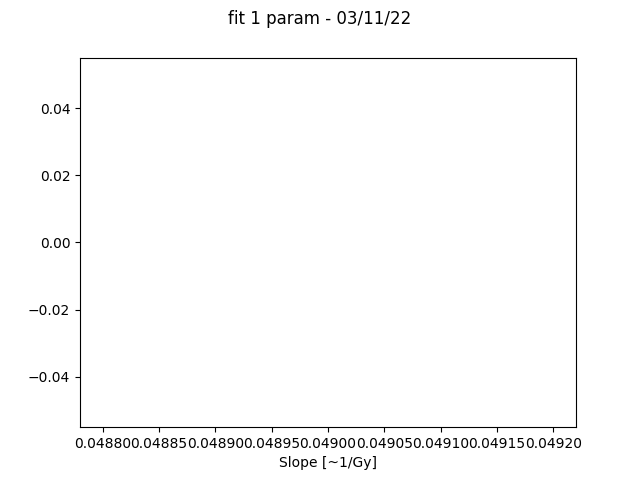

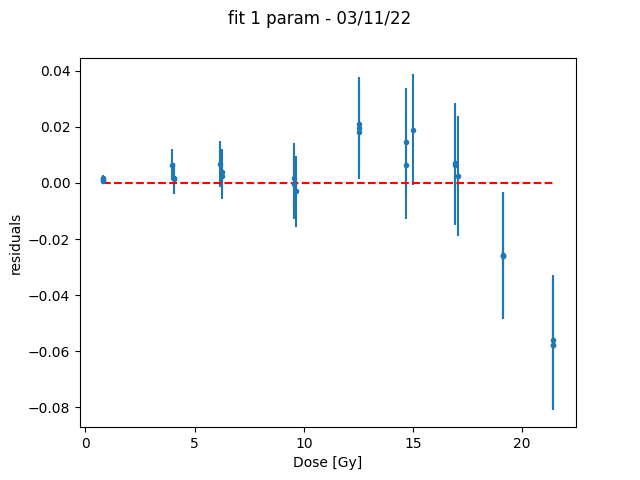

In [128]:
#Make a fit of the line, normalising to the biggest value  
normalizationPointIndex = -1

fitParam=[]
for r in range(0, len(rROI)):
    x = dataForDifferentROIs[r][0]
    y = dataForDifferentROIs[r][1]
    dy = dataForDifferentROIs[r][2]
    normalizationValue=y[normalizationPointIndex]
    y = y/normalizationValue
    dy = dy/normalizationValue
    opt, optErr = fitLineOneParam(x, y, dy)
    fitParam.append(opt)    
fitParam=np.array(fitParam)

fig, ax = plt.subplots(1,1)
ax.set_xlabel("Slope [~1/Gy]")
ax.hist(fitParam[:,0], bins= np.linspace(0.0488, 0.0492, 10))
fig.suptitle("fit 1 param - "+title)

#Look at residuals
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Dose [Gy]")
ax.set_ylabel("residuals")
fig.suptitle("fit 1 param - "+title)

for r in range(0, len(rROI)):
    x = dataForDifferentROIs[r][0]
    y = dataForDifferentROIs[r][1]
    dy = dataForDifferentROIs[r][2]
    normalizationValue=y[normalizationPointIndex]
    y = y/normalizationValue
    dy = dy/normalizationValue
    ax.errorbar(x, y-lineOneParam(x,*fitParam[r]), yerr=dy, fmt='.')
ax.plot(np.linspace(x.min(), x.max(), 1000), line(np.linspace(x.min(), x.max(), 1000), 0, 0), '--r')



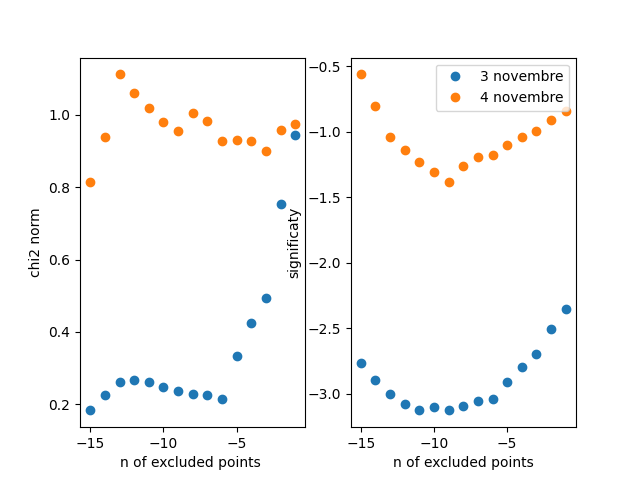

In [129]:
#3 Novembre
chi2Norm_1 = [0.9458, 0.7528, 0.4924, 0.4248, 0.3344, 0.2155, 0.225,  0.2271, 0.2363, 0.2486, 0.2617, 0.2676, 0.2612, 0.2261, 0.1826] 
significaty_3 = [-2.3494, -2.507,  -2.6926, -2.7922, -2.9078, -3.0421, -3.0573, -3.0954, -3.1206, -3.1015, -3.1256, -3.0766, -3.0035, -2.8909, -2.7625]
nOfExcludedPoints = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15]

#4 novembre
chi2Norm_4 = [0.9738, 0.9579, 0.9012, 0.9265, 0.9308, 0.9284, 0.9843, 1.0045, 0.9559, 0.9801, 1.019,  1.0616, 1.1121, 0.9393,
            0.8153] 
significaty_4 = [-0.8408, -0.9077, -0.9981, -1.0397, -1.1032, -1.1759, -1.19,   -1.2609, -1.3831, -1.3054, -1.2285, -1.1398, -1.0414, -0.8018, -0.5635]


fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_xlabel("n of excluded points ")
ax1.set_ylabel("chi2 norm")
ax1.plot(nOfExcludedPoints, chi2Norm_1, 'o', label = '3 novembre')
ax1.plot(nOfExcludedPoints, chi2Norm_4, 'o', label = '4 novembre')
ax2.set_xlabel("n of excluded points")
ax2.set_ylabel("significaty")
ax2.plot(nOfExcludedPoints, significaty_3, 'o', label = '3 novembre')
ax2.plot(nOfExcludedPoints, significaty_4, 'o', label = '4 novembre')
plt.legend()